In [0]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Input, Concatenate, Conv2D, LeakyReLU, Conv2DTranspose, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
import numpy as np
import pandas as pd
import tensorflow as tf

In [0]:
(x_tr, y_tr), (x_ts, y_ts) = cifar10.load_data()

Scale images from -1 to 1 as it's preferable for GAN models.

In [0]:
x_tr, x_ts = x_tr/255.*2-1, x_ts/255.*2-1

In func for **discriminator** we use simple Conv2D layers with LeakyReLu activation func (which is also preferable rather than simple ReLu).

In [0]:
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In func for **generator** we're using method of deconvolution: first by making small representation of image in Dense layer and then transfering this to Conv2DTranspose layers and in the end we have 32x32 image. The last layer is Conv2D with 3 inputs for colors - RGB and the activation func is tanh in order to keep our values from -1 to 1. And as you can see we have no metrics here, as the role of the func to generate images for discriminator and the last one is going to evaluate them.

In [0]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

Now our combined model, where we set **discriminator.trainbale** to False.

In [0]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

There are functions for generating real and fake samples both with lables 1/0.

In [0]:
def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y

A dir for our images.

In [0]:
import os
if not os.path.exists('/content/gan_images'):
  os.makedirs('/content/gan_images')

Func which will plot our "fake" images and save them to dir. 

In [0]:
def sample_images(epoch, examples):
  rows, cols = 5, 5
  examples = (examples + 1) / 2.0
  idx = 0
  fig, ax = plt.subplots(rows, cols)
  for i in range(rows):
    for j in range(cols):
      ax[i][j].imshow(examples[idx])
      ax[i][j].axis('off')
      idx += 1
  fig.savefig('/content/gan_images/%d.png' % epoch)

In [0]:
import matplotlib.pyplot as plt

In [0]:
os.makedirs('/content/gen_models')

In [0]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  sample_images(epoch, x_fake)
  # save our generator at the required epoch
  file_path = '/content/gen_models/generator_model_%03d.h5' % (epoch+1)
  g_model.save(file_path)

**Train process**. You can also save average losses for discriminator and for generator in list and then plot them. You can try to play with the number of epochs. So our 1st step - train discriminator both on real and fake images (we do this separately as GAN models require), 2nd step - prepare generator and feed it to our combined GAN model, 3rd step - print the main statiscs and the summary with plots.

In [0]:
d_losses = []
g_losses = []
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, d_acc_real = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, d_acc_fake = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
		# evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
    g_losses.append(g_loss)
    d_losses.append((d_loss_real + d_loss_fake)/2)

Streaming output truncated to the last 5000 lines.
>188, 74/390, d1=0.618, d2=0.474 g=1.329
>188, 75/390, d1=0.501, d2=0.553 g=1.276
>188, 76/390, d1=0.599, d2=0.460 g=1.239
>188, 77/390, d1=0.606, d2=0.482 g=1.304
>188, 78/390, d1=0.555, d2=0.594 g=1.380
>188, 79/390, d1=0.520, d2=0.397 g=1.338
>188, 80/390, d1=0.515, d2=0.519 g=1.279
>188, 81/390, d1=0.510, d2=0.438 g=1.203
>188, 82/390, d1=0.487, d2=0.502 g=1.177
>188, 83/390, d1=0.592, d2=0.489 g=1.272
>188, 84/390, d1=0.558, d2=0.575 g=1.311
>188, 85/390, d1=0.542, d2=0.477 g=1.364
>188, 86/390, d1=0.664, d2=0.490 g=1.348
>188, 87/390, d1=0.545, d2=0.417 g=1.237
>188, 88/390, d1=0.582, d2=0.652 g=1.224
>188, 89/390, d1=0.503, d2=0.483 g=1.261
>188, 90/390, d1=0.532, d2=0.519 g=1.351
>188, 91/390, d1=0.540, d2=0.539 g=1.280
>188, 92/390, d1=0.576, d2=0.662 g=1.241
>188, 93/390, d1=0.468, d2=0.495 g=1.233
>188, 94/390, d1=0.590, d2=0.554 g=1.309
>188, 95/390, d1=0.561, d2=0.481 g=1.230
>188, 96/390, d1=0.584, d2=0.533 g=1.430
>188, 

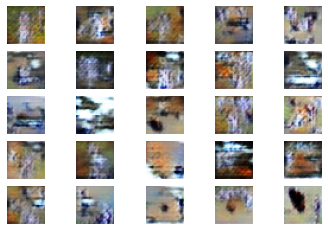

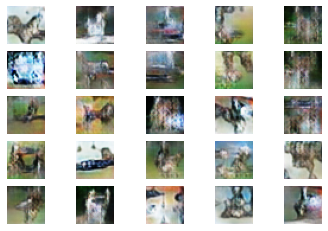

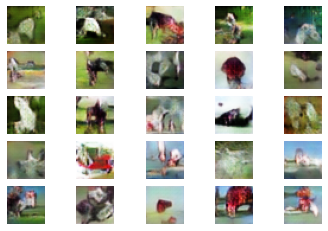

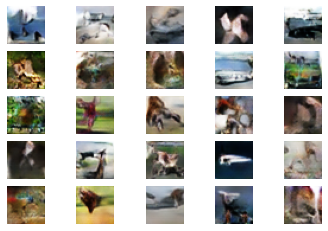

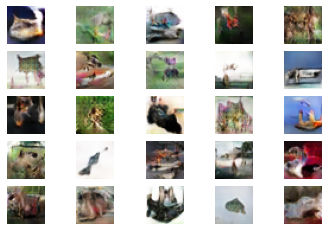

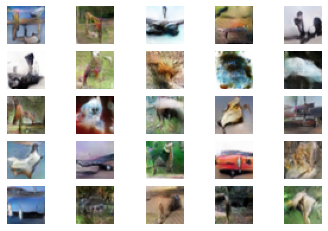

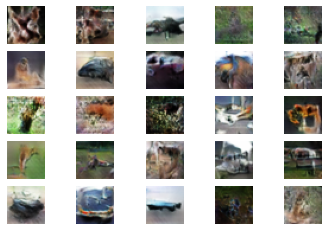

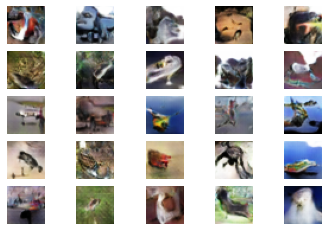

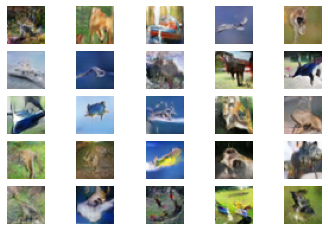

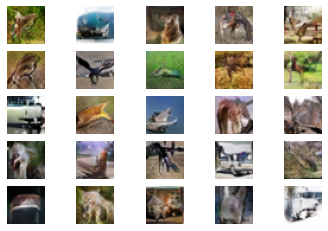

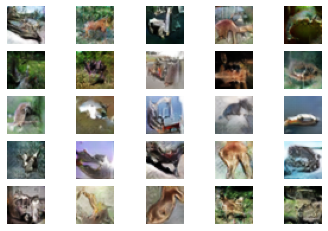

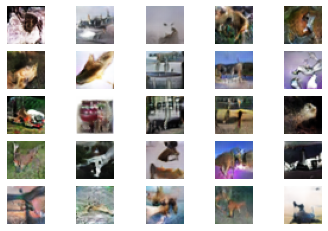

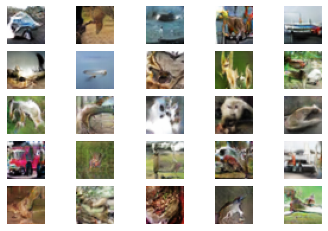

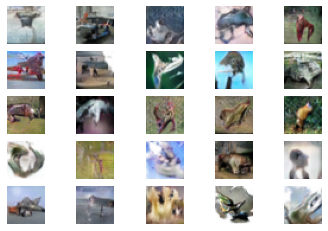

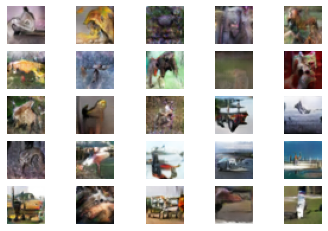

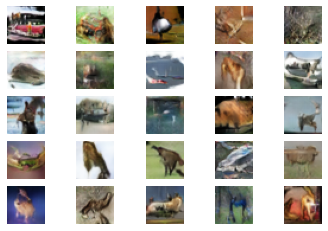

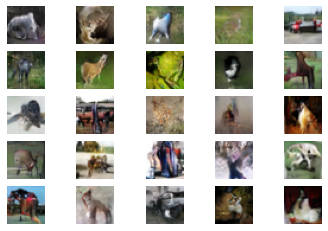

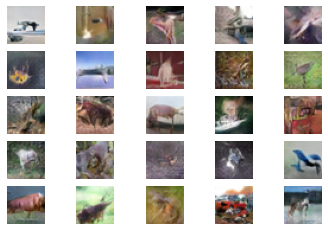

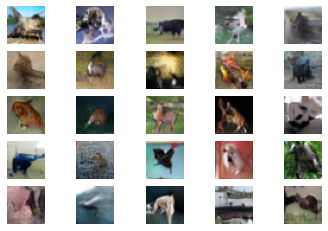

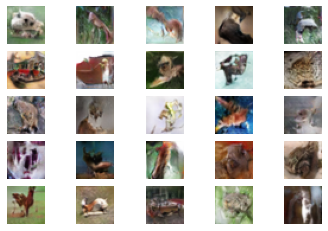

In [17]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
train(g_model, d_model, gan_model, x_tr, latent_dim)

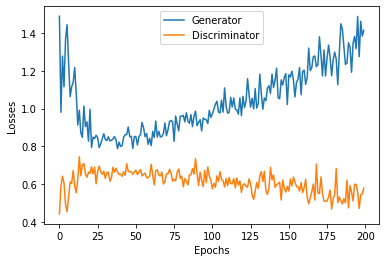

In [38]:
# as the rule, G's and D's losses won't decrease, they always will be at the same level
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.legend()
plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.show()

Now you can look through the images we have. As you can see our model isn't the best, so we can improve it to have better results.

In [0]:
from tensorflow.keras.preprocessing.image import load_img

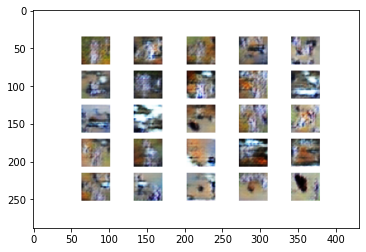

In [20]:
im = load_img('/content/gan_images/9.png')
plt.imshow(im)

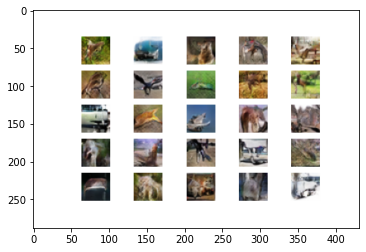

In [21]:
im = load_img('/content/gan_images/99.png')
plt.imshow(im)

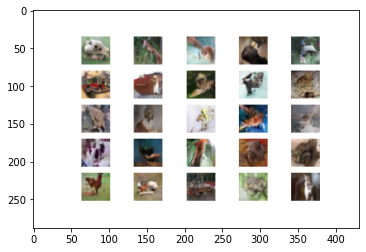

In [22]:
im = load_img('/content/gan_images/199.png')
plt.imshow(im)

And now we can load our last model and genearte new images.

In [0]:
def make_plot(image):
  rows, cols = 3, 3
  for n in range(rows*cols):
    plt.subplot(rows,cols,n+1)
    plt.imshow(image[n])
    plt.axis('off')
  plt.show()

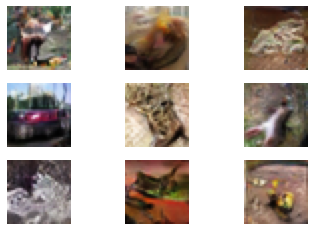

In [30]:
from tensorflow.keras.models import load_model
model = load_model('/content/gen_models/generator_model_200.h5')
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
X = (X + 1) / 2.0
make_plot(X) # we can see here a car (1,0), the orther images are hard to be understood